In [6]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
#from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import RepeatVector
from keras.layers import Dropout
from numpy import hstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [7]:
!pip3 install keras --upgrade

In [8]:
def augmento_sent(symbol):
    dataset= pd.read_csv('augmento_{}.csv'.format(symbol))
    col=dataset.columns
    #Choosen Bad&Good
    imp_col_index_good=[40,41,93,25,75]
    imp_col_index_bad=[28,16,3,55,16,8,75,56,87]
    #Timestamp
    icolindex_good=[0]
    icolindex_bad=[0]
    #Extend counting of good 
    icolindex_good.extend([i for i in imp_col_index_good])
    icolindex_good.extend([i+93 for i in imp_col_index_good])
    icolindex_good.extend([i+93*2 for i in imp_col_index_good]) 
    #Extend counting of bad
    icolindex_bad.extend([i for i in imp_col_index_bad])
    icolindex_bad.extend([i+93 for i in imp_col_index_bad])
    icolindex_bad.extend([i+93*2 for i in imp_col_index_bad])
    #date 
    dataset_good=dataset.loc[:,col[icolindex_good]]
    dataset_bad=dataset.loc[:,col[icolindex_bad]]
    #time to date
    dataset_good['date']=pd.to_datetime(dataset_good['date']).dt.date
    dataset_bad['date']=pd.to_datetime(dataset_bad['date']).dt.date
    #sum arrange
    dataset_good=dataset_good.groupby('date').sum().sum(axis=1)
    dataset_bad=dataset_bad.groupby('date').sum().sum(axis=1)
    dataset= pd.concat([dataset_good,dataset_bad],axis=1)
    #create new dataset
    dataset=dataset.rename(columns={0:'pos',1:'neg'})
    dataset['sentiment']=(dataset['pos']-dataset['neg'])/(dataset['pos']+dataset['neg'])
    return dataset['sentiment']

def daily_coin(symbol):
    dataset= pd.read_csv('{}_daily.csv'.format(symbol))
    dataset['timestamp']=pd.date_range(start="2016-11-04",end="2022-01-18")
    dataset.index=dataset['timestamp']
    return dataset

In [9]:
def calc_rsi(dataset):
    dataset = pd.DataFrame(dataset,columns=["open","high","low","close"])
    coin_rsi=dataset.copy()
    data=coin_rsi.copy()
    a=coin_rsi.columns[3]
    coin_rsi.drop(coin_rsi.columns.difference([a]), 1, inplace=True)
    coin_rsi=coin_rsi.reset_index(drop=True,inplace=False)
    coin_rsi["diff"]=coin_rsi.diff(1)

    coin_rsi['gain'] = coin_rsi['diff'].clip(lower=0).round(2)
    coin_rsi['loss'] = coin_rsi['diff'].clip(upper=0).abs().round(2)
    coin_rsi

    window_length=14
    # Get initial Averages
    coin_rsi['avg_gain'] = coin_rsi['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    coin_rsi['avg_loss'] = coin_rsi['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    # View Result

    # View first SMA value

    for i, row in enumerate(coin_rsi['avg_gain'].iloc[window_length+1:]):
        coin_rsi['avg_gain'].iloc[i + window_length + 1] =\
          (coin_rsi['avg_gain'].iloc[i + window_length] *
          (window_length - 1) +
          coin_rsi['gain'].iloc[i + window_length + 1])\
          / window_length
    # Average Losses
    for i, row in enumerate(coin_rsi['avg_loss'].iloc[window_length+1:]):
        coin_rsi['avg_loss'].iloc[i + window_length + 1] =\
          (coin_rsi['avg_loss'].iloc[i + window_length] *
          (window_length - 1) +
          coin_rsi['loss'].iloc[i + window_length + 1])\
          / window_length
    # View initial results

    coin_rsi['rs'] = coin_rsi['avg_gain'] / coin_rsi['avg_loss']
    coin_rsi['rsi'] = 100 - (100 / (1.0 + coin_rsi['rs']))

    # View Result

    return coin_rsi["rsi"]

In [10]:
Sentiment_btc=augmento_sent("btc")
Sentiment_eth=augmento_sent("eth")

FileNotFoundError: [Errno 2] No such file or directory: 'augmento_btc.csv'

In [11]:
btc_price=daily_coin('btc')
eth_price=daily_coin('eth')

FileNotFoundError: [Errno 2] No such file or directory: 'btc_daily.csv'

In [12]:
btc_rsi=calc_rsi(btc_price)
btc_rsi.index=btc_price['timestamp']
btc_price['rsi']=btc_rsi
eth_rsi=calc_rsi(eth_price)
eth_rsi.index=eth_price['timestamp']
eth_price['rsi']=eth_rsi

NameError: name 'btc_price' is not defined

In [13]:
eth_price["rsi"][eth_price["rsi"].isnull()]=0
btc_price["rsi"][btc_price["rsi"].isnull()]=0

NameError: name 'eth_price' is not defined

In [32]:
eth_dataset= pd.concat([Sentiment_eth,eth_price],axis=1)
eth_dataset=eth_dataset.dropna()
eth_dataset=eth_dataset.reset_index(drop=True)
eth_dataset=eth_dataset[['rsi','open','high','low','close']]#[['pos','neg','sentiment','open','high','low','close']]

In [33]:
btc_dataset= pd.concat([Sentiment_btc,btc_price],axis=1)
btc_dataset=btc_dataset.dropna()
btc_dataset=btc_dataset.reset_index(drop=True)
btc_dataset=btc_dataset[['rsi','open','high','low','close']]#[['pos','neg','sentiment','open','high','low','close']]

In [34]:
btc_dataset

,rsi,open,high,low,close
0,0.000000,689.509491,709.126580,683.607847,704.062564
1,0.000000,706.525747,711.970714,688.419083,705.317849
2,0.000000,705.218603,727.649078,698.696389,714.088571
3,0.000000,714.304753,717.923857,692.294478,700.064307
4,0.000000,704.857515,715.910096,694.852902,712.547405
...,...,...,...,...,...
1897,39.537047,42551.920860,43473.451290,41747.421360,43085.569720
1898,39.587058,43086.525530,43818.194650,42575.566830,43095.616600
1899,39.582708,43109.999780,43494.501220,42601.490020,43094.373970
1900,36.537277,43092.255750,43198.463160,41561.645930,42221.051690


In [35]:
eth_dataset

,rsi,open,high,low,close
0,0.000000,10.842009,11.215637,10.744287,11.202714
1,0.000000,11.149229,11.232777,10.772639,11.127560
2,0.000000,11.120714,11.334937,10.850349,10.928217
3,0.000000,10.996574,11.140000,10.638606,10.929104
4,0.000000,10.910079,11.211000,10.723212,10.856283
...,...,...,...,...,...
1897,40.551543,3239.772682,3344.659990,3189.507406,3309.548034
1898,41.284706,3309.601722,3373.669878,3262.423862,3327.493118
1899,42.191919,3328.462037,3394.339589,3273.415898,3348.706159
1900,38.078660,3348.794862,3359.161081,3142.430999,3211.012028


In [36]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [37]:
def modelling(dataset):
    # choose a number of time steps
    n_steps = 3

    # convert into input/output
    #scaler = MinMaxScaler(feature_range=(0,1))
    pre_dataset=dataset.values#scaler.fit_transform(np.array(dataset).reshape(-1,5))

    X, y = split_sequences(pre_dataset[:1500,:], n_steps)
    X_valid, y_valid = split_sequences(pre_dataset[1500:,:], n_steps)
    # the dataset knows the number of features, e.g. 2
    n_features = X.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))#,return_sequences=True
    #model.add(Dropout(0.4))
    #model.add(BatchNormalization())
    #model.add(LSTM(60, return_sequences=True, activation='relu'))
    #model.add(Dropout(0.4))
    #model.add(BatchNormalization())
    #model.add(LSTM(32, activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    #model.add(Dense(20))
    #model.add(Dropout(0.2))
    model.add(Dense(1)) #activation="linear"))

    model.compile(optimizer='adam', loss='mse')
    # fit model
    history=model.fit(X, y,validation_data=(X_valid,y_valid), epochs=120)
    return model,X,y,X_valid,y_valid

In [38]:
btc_model,btc_X,btc_y,btc_X_valid,btc_y_valid=modelling(btc_dataset)
eth_model,eth_X,eth_y,eth_X_valid,eth_y_valid=modelling(eth_dataset)

Epoch 1/120
47/47 [==============================] - 3s 21ms/step - loss: 37559606.0833 - val_loss: 3036168.7500
Epoch 2/120
47/47 [==============================] - 0s 9ms/step - loss: 211218.6603 - val_loss: 4633711.0000
Epoch 3/120
47/47 [==============================] - 0s 9ms/step - loss: 178963.8441 - val_loss: 4407288.5000
Epoch 4/120
47/47 [==============================] - 0s 9ms/step - loss: 178000.1624 - val_loss: 5364108.5000
Epoch 5/120
47/47 [==============================] - 0s 8ms/step - loss: 152507.0955 - val_loss: 4495454.0000
Epoch 6/120
47/47 [==============================] - 0s 9ms/step - loss: 166498.6468 - val_loss: 4449294.5000
Epoch 7/120
47/47 [==============================] - 0s 8ms/step - loss: 176501.9827 - val_loss: 5035440.5000
Epoch 8/120
47/47 [==============================] - 0s 9ms/step - loss: 176410.6370 - val_loss: 4578524.0000
Epoch 9/120
47/47 [==============================] - 0s 9ms/step - loss: 156874.2293 - val_loss: 3906753.5000
Epoch 1

47/47 [==============================] - 0s 8ms/step - loss: 242.0361 - val_loss: 18400.0020
Epoch 30/120
47/47 [==============================] - 0s 8ms/step - loss: 194.0068 - val_loss: 11867.0967
Epoch 31/120
47/47 [==============================] - 0s 8ms/step - loss: 215.1651 - val_loss: 16640.9316
Epoch 32/120
47/47 [==============================] - 0s 8ms/step - loss: 186.8535 - val_loss: 10385.6191
Epoch 33/120
47/47 [==============================] - 0s 8ms/step - loss: 238.4810 - val_loss: 9756.2627
Epoch 34/120
47/47 [==============================] - 0s 8ms/step - loss: 230.9705 - val_loss: 13195.4512
Epoch 35/120
47/47 [==============================] - 0s 8ms/step - loss: 221.2322 - val_loss: 10042.0879
Epoch 36/120
47/47 [==============================] - 0s 8ms/step - loss: 284.9661 - val_loss: 9228.6543
Epoch 37/120
47/47 [==============================] - 0s 8ms/step - loss: 184.1508 - val_loss: 10246.5059
Epoch 38/120
47/47 [==============================] - 0s 8ms/

47/47 [==============================] - 0s 9ms/step - loss: 93.8326 - val_loss: 7049.3794
Epoch 108/120
47/47 [==============================] - 0s 8ms/step - loss: 82.9303 - val_loss: 5697.1318
Epoch 109/120
47/47 [==============================] - 0s 8ms/step - loss: 76.5681 - val_loss: 6292.0977
Epoch 110/120
47/47 [==============================] - 0s 8ms/step - loss: 71.7423 - val_loss: 7448.9707
Epoch 111/120
47/47 [==============================] - 0s 8ms/step - loss: 72.3273 - val_loss: 8221.6650
Epoch 112/120
47/47 [==============================] - 0s 8ms/step - loss: 93.9262 - val_loss: 4535.2266
Epoch 113/120
47/47 [==============================] - 0s 8ms/step - loss: 82.9004 - val_loss: 7671.1704
Epoch 114/120
47/47 [==============================] - 0s 8ms/step - loss: 108.3658 - val_loss: 12031.0010
Epoch 115/120
47/47 [==============================] - 0s 8ms/step - loss: 115.0633 - val_loss: 5814.8223
Epoch 116/120
47/47 [==============================] - 0s 8ms/step

In [39]:
import numpy as np

def form(yhat,y):
    conf=[[[],[]],#0
          [[],[]],#1
          [[],[]],#2
          [[],[]],#3
          [[],[]]] #4
    i=1
    while i<len(yhat):
        if yhat[i]<y[i-1] and y[i]<y[i-1]:
            conf[3][0].append(abs(yhat[i]-y[i]))
            conf[3][1].append(abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(True)
            conf[4][1].append(1+abs(y[i-1]-y[i])/y[i-1])
        elif yhat[i]>y[i-1] and y[i]>y[i-1]:
            conf[0][0].append(abs(yhat[i]-y[i]))
            conf[0][1].append(abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(True)
            conf[4][1].append(1+abs(y[i-1]-y[i])/y[i-1])
        elif yhat[i]>y[i-1] and y[i]<y[i-1]:
            conf[2][0].append(abs(yhat[i]-y[i]))
            conf[2][1].append(-1*abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(False)
            conf[4][1].append(1-abs(y[i-1]-y[i])/y[i-1])
        else:
            conf[1][0].append(abs(yhat[i]-y[i]))
            conf[1][1].append(-1*abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(False)
            conf[4][1].append(1-abs(y[i-1]-y[i])/y[i-1])
        i+=1
    
    print('Mean')
    print([[np.mean(i) for i in j] for j in conf])
    print('Count')
    print([len(i[0]) for i in conf])
    print("acc: %{}".format((len(conf[0][0])+len(conf[3][0]))/(len(conf[0][0])+len(conf[3][0])+len(conf[1][0])+len(conf[2][0]))))
    print('Max')
    print([[np.max(i) for i in j] for j in conf])
    print('Min')
    print([[np.min(i) for i in j] for j in conf])
    money=100

    for i in range(len(conf[4][1])):
        #print(money)
        money=(money*conf[4][1][i])#+money*0.2
        money*=0.988
    return money

In [40]:
btc_yhat = btc_model.predict(btc_X)
btc_yhat_valid = btc_model.predict(btc_X_valid)
form(btc_yhat,btc_y)

Mean
[[114.80788, 0.03428825281326887], [144.44106, -0.008936616965539098], [63.156147, -0.007823512418352907], [84.43737, 0.03085515980903846], [0.8176352705410822, 1.0251270487188775]]
Count
[637, 182, 91, 587, 1497]
acc: %0.8176352705410822
Max
[[1808.1152, 0.27502328089469147], [899.95703, -3.8462730264935205e-05], [518.03955, -1.6389615947945367e-05], [1052.4297, 0.39013325854584713], [True, 1.390133258545847]]
Min
[[0.045410156, 1.6216279396242007e-06], [3.3208008, -0.05332942598499158], [6.6157227, -0.0443348270618088], [0.092041016, 8.778549982866637e-05], [False, 0.9466705740150084]]


8619673293.270102

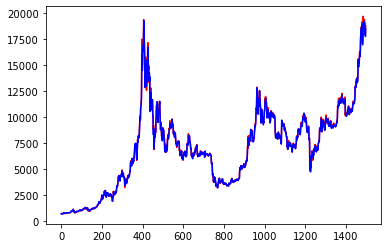

In [41]:
fig, btc_ax = plt.subplots()
btc_ax.plot(btc_y,color="r")
btc_ax.plot(btc_yhat,color="b")

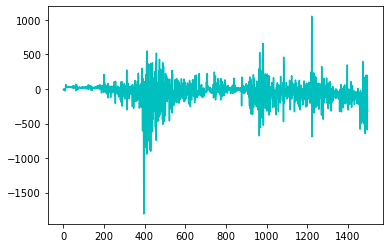

In [42]:
btc_y=btc_y.reshape((btc_y.shape[0],1))
btc_dif_y=btc_yhat-btc_y
fig, btc_ax = plt.subplots()#figsize=(120, 60)
btc_ax.plot(btc_dif_y,color='c')

In [43]:
form(btc_yhat_valid,btc_y_valid)

Mean
[[978.31726, 0.04124397922042908], [1161.7794, -0.01320827304085972], [690.9564, -0.006018107613565122], [621.37695, 0.03084908665476991], [0.8120300751879699, 1.0265534342809293]]
Count
[144, 62, 13, 180, 399]
acc: %0.8120300751879699
Max
[[3696.621, 0.19510779364778952], [3722.332, -0.0002331843367812775], [1161.9844, -0.0002338967859314445], [9047.848, 0.14498277737817103], [True, 1.1951077936477894]]
Min
[[1.8320312, 3.7493373567202853e-06], [56.41797, -0.036696131782947], [238.57812, -0.019797446089817164], [2.7382812, 2.883425503652371e-05], [False, 0.963303868217053]]


23163.654285439356

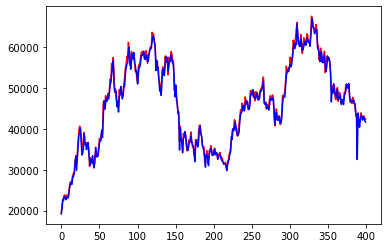

In [44]:
fig, btc_ax = plt.subplots()
btc_ax.plot(btc_y_valid,color="r")
btc_ax.plot(btc_yhat_valid,color="b")

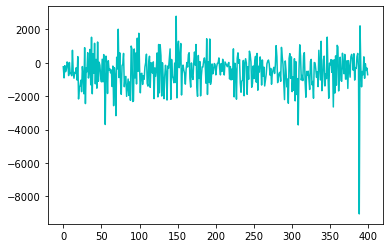

In [45]:
btc_y_valid=btc_y_valid.reshape((btc_y_valid.shape[0],1))
btc_dif_y_valid=btc_yhat_valid-btc_y_valid
fig, btc_ax = plt.subplots()#figsize=(120, 60)
btc_ax.plot(btc_dif_y_valid,color='c')

In [46]:
eth_yhat = eth_model.predict(eth_X)
eth_yhat_valid = eth_model.predict(eth_X_valid)
form(eth_yhat,eth_y)

Mean
[[4.35209, 0.04403546024325163], [3.8865232, -0.011026538115846243], [6.0702567, -0.008746692940807625], [5.0273185, 0.04195100508712184], [0.8663994655978624, 1.0360911080875193]]
Count
[715, 54, 146, 582, 1497]
acc: %0.8663994655978624
Max
[[62.557983, 0.29217740146982335], [28.967926, -1.671071489576322e-05], [65.733765, -6.0442905334623365e-05], [76.2135, 0.4410633634812707], [True, 1.4410633634812706]]
Min
[[0.0021648407, 4.6698227304356306e-05], [0.073654175, -0.05624660003730986], [0.06861687, -0.03960612982002211], [0.00017929077, 6.40024944115669e-05], [False, 0.9437533999626901]]


4.349930417414262e+16

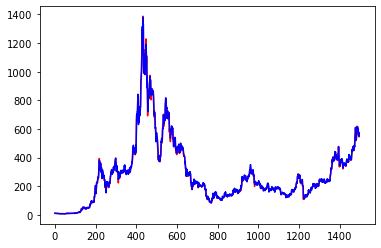

In [47]:
fig, eth_ax = plt.subplots()
eth_ax.plot(eth_y,color="r")
eth_ax.plot(eth_yhat,color="b")

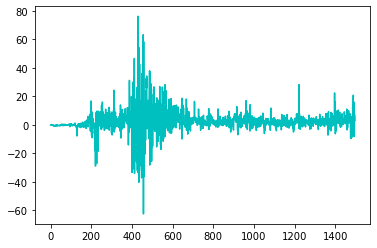

In [48]:
eth_y=eth_y.reshape((eth_y.shape[0],1))
eth_dif_y=eth_yhat-eth_y
fig, eth_ax = plt.subplots()#figsize=(120, 60)
eth_ax.plot(eth_dif_y,color='c')

In [49]:
form(eth_yhat_valid,eth_y_valid)

Mean
[[55.285538, 0.05007585118302496], [63.97443, -0.012771526990928867], [52.748417, -0.01638791938518883], [47.524727, 0.04222458249972859], [0.8421052631578947, 1.0368470204743072]]
Count
[174, 50, 13, 162, 399]
acc: %0.8421052631578947
Max
[[184.9143, 0.2642298752386079], [236.354, -1.7316388982556728e-05], [144.7666, -0.0019631289181387033], [273.83228, 0.2765006568953808], [True, 1.2765006568953807]]
Min
[[0.25634766, 0.0003762865777129519], [4.2163086, -0.03895934116871288], [8.942932, -0.05578404417840155], [0.3383789, 0.002206187994352216], [False, 0.9442159558215985]]


1103532.93498258

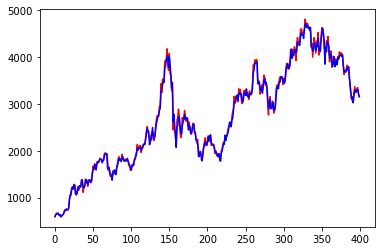

In [50]:
fig, eth_ax = plt.subplots()
eth_ax.plot(eth_y_valid,color="r")
eth_ax.plot(eth_yhat_valid,color="b")

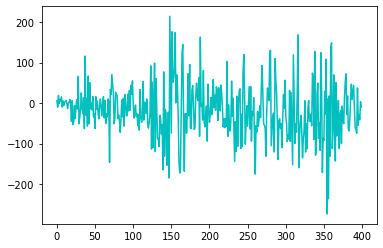

In [51]:
eth_y_valid=eth_y_valid.reshape((eth_y_valid.shape[0],1))
eth_dif_y_valid=eth_yhat_valid-eth_y_valid
fig, eth_ax = plt.subplots()#figsize=(120, 60)
eth_ax.plot(eth_dif_y_valid,color='c')

In [86]:
import numpy as np

def form(yhat,y):
    conf=[[[],[]],#0
          [[],[]],#1
          [[],[]],#2
          [[],[]],#3
          [[],[]]] #4
    i=1
    while i<len(yhat):
        if yhat[i]<y[i-1] and y[i]<y[i-1]:
            conf[3][0].append(abs(yhat[i]-y[i]))
            conf[3][1].append(abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(True)
            conf[4][1].append(1+abs(y[i-1]-y[i])/y[i-1])
        elif yhat[i]>y[i-1] and y[i]>y[i-1]:
            conf[0][0].append(abs(yhat[i]-y[i]))
            conf[0][1].append(abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(True)
            conf[4][1].append(1+abs(y[i-1]-y[i])/y[i-1])
        elif yhat[i]>y[i-1] and y[i]<y[i-1]:
            conf[2][0].append(abs(yhat[i]-y[i]))
            conf[2][1].append(-1*abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(False)
            conf[4][1].append(1-abs(y[i-1]-y[i])/y[i-1])
        else:
            conf[1][0].append(abs(yhat[i]-y[i]))
            conf[1][1].append(-1*abs(y[i-1]-y[i])/y[i-1])
            conf[4][0].append(False)
            conf[4][1].append(1-abs(y[i-1]-y[i])/y[i-1])
        i+=1
    
    #print('Mean')
    #print([[np.mean(i) for i in j] for j in conf])
    #print('Count')
    #print([len(i[0]) for i in conf])
    #print("acc: %{}".format((len(conf[0][0])+len(conf[3][0]))/(len(conf[0][0])+len(conf[3][0])+len(conf[1][0])+len(conf[2][0]))))
    #print('Max')
    #print([[np.max(i) for i in j] for j in conf])
    #print('Min')
    #print([[np.min(i) for i in j] for j in conf])
    money=100

    for i in range(len(conf[4][1])):
        #print(money)
        money=(money*conf[4][1][i])#+money*0.2
        money*=0.988
    print(money)
    return

In [87]:
btc=form(btc_yhat_valid,btc_y_valid)
etc=form(eth_yhat_valid,eth_y_valid)

[23163.65428544]
[1103532.93498258]


In [93]:
from termcolor import colored
def optimizer(yhat,y):
    conf=[[1 for i in range(4)] for j in range(len(yhat))]
    money=100
    i=1
    while i<len(yhat[0]):
        print("-----",i,". Day ------:")
        print("Currency:",money)
        #sum
        j=0
        sumi=0
        while j<len(yhat):
            if yhat[j][i]<y[j][i-1]:  
                sumi+=(conf[j][3]/(conf[j][1]+conf[j][3]))*(1+abs(yhat[j][i]-y[j][i-1])/y[j][i-1])
            else:
                sumi+=(conf[j][0]/(conf[j][2]+conf[j][0]))*(1+abs(yhat[j][i]-y[j][i-1])/y[j][i-1])
            j+=1
        #prob roulete
        roulete=[]
        j=0
        while j<len(yhat):
            if yhat[j][i]<y[j][i-1]:  
                roulete.append(money*((conf[j][3]/(conf[j][1]+conf[j][3]))*(1+abs(yhat[j][i]-y[j][i-1])/y[j][i-1]))/sumi)
                print(j,".coin :",roulete[-1][0]," short")
            else:
                roulete.append(money*((conf[j][0]/(conf[j][2]+conf[j][0]))*(1+abs(yhat[j][i]-y[j][i-1])/y[j][i-1]))/sumi)
                print(j,".coin :",roulete[-1][0]," long")
            j+=1
        
        print("----Real----")
        j=0
        while j<len(yhat):   
            if yhat[j][i]<y[j][i-1] and y[j][i]<y[j][i-1]:
                roulete[j]=roulete[j]*(1+abs(y[j][i-1]-y[j][i])/y[j][i-1])
                print(j,".coin profit:",abs(y[j][i-1]-y[j][i])/y[j][i-1])
                conf[j][0]+=abs(y[j][i-1]-y[j][i])/y[j][i-1]
            elif yhat[j][i]>y[j][i-1] and y[j][i]>y[j][i-1]:
                roulete[j]=roulete[j]*(1+abs(y[j][i-1]-y[j][i])/y[j][i-1])
                print(j,".coin profit:",abs(y[j][i-1]-y[j][i])/y[j][i-1])
                conf[j][3]+=abs(y[j][i-1]-y[j][i])/y[j][i-1]
            elif yhat[j][i]>y[j][i-1] and y[j][i]<y[j][i-1]:
                roulete[j]=roulete[j]*(1-abs(y[j][i-1]-y[j][i])/y[j][i-1])
                print(j,".coin lose :",abs(y[j][i-1]-y[j][i])/y[j][i-1])
                conf[j][1]+=-abs(y[j][i-1]-y[j][i])/y[j][i-1]
            else:
                roulete[j]=roulete[j]*(1-abs(y[j][i-1]-y[j][i])/y[j][i-1])
                print(j,".coin lose :",abs(y[j][i-1]-y[j][i])/y[j][i-1])
                conf[j][2]+=-abs(y[j][i-1]-y[j][i])/y[j][i-1]
            j+=1
        
        if sum(roulete)>money:
            print("Total profit:%",colored(sum(roulete)/money-1,"blue"))
        else:
            print("Total Lose:%",colored(money/sum(roulete)-1,"red"))
        #print("Final Money:",money)
        money=sum(roulete)
        money*=0.988
        i+=1
        print("Final Currency:",money,"\n\n")
    return 
        

In [94]:
optimizer([btc_yhat_valid,eth_yhat_valid],[btc_y_valid,eth_y_valid])


----- 1 . Day ------:
Currency: 100
0 .coin : 49.67813118445805  long
1 .coin : 50.32186881554195  long
----Real----
0 .coin profit: [0.09890441]
1 .coin profit: [0.08284075]
Total profit:% [0.09082087]
Final Currency: [108.64575904] 


----- 2 . Day ------:
Currency: [108.64575904]
0 .coin : 54.89457080275889  long
1 .coin : 53.75118823827066  long
----Real----
0 .coin profit: [0.06800007]
1 .coin profit: [0.00821129]
Total profit:% [0.03842028]
Final Currency: [112.36868018] 


----- 3 . Day ------:
Currency: [112.36868018]
0 .coin : 58.08123132465514  short
1 .coin : 54.287448851926506  long
----Real----
0 .coin lose : [0.0143369]
1 .coin profit: [0.01792671]
Total profit:% [0.00125026]
Final Currency: [112.05913391] 


----- 4 . Day ------:
Currency: [112.05913391]
0 .coin : 56.06444025637641  long
1 .coin : 55.99469365411485  long
----Real----
0 .coin profit: [0.03079723]
1 .coin profit: [0.00638937]
Total profit:% [0.0186009]
Final Currency: [113.68696042] 


----- 5 . Day ------

0 .coin lose : [0.01979745]
1 .coin profit: [0.08627828]
Total profit:% [0.03526072]
Final Currency: [351.84896172] 


----- 36 . Day ------:
Currency: [351.84896172]
0 .coin : 171.67852339744903  short
1 .coin : 180.17043832493673  short
----Real----
0 .coin profit: [0.01140246]
1 .coin lose : [0.00786635]
Total profit:% [0.00153553]
Final Currency: [350.97967855] 


----- 37 . Day ------:
Currency: [350.97967855]
0 .coin : 168.74652659136268  short
1 .coin : 182.2331519571196  short
----Real----
0 .coin profit: [0.131433]
1 .coin profit: [0.19401121]
Total profit:% [0.16392441]
Final Currency: [406.8797595] 


----- 38 . Day ------:
Currency: [406.8797595]
0 .coin : 195.9397583482952  long
1 .coin : 210.94000115534442  long
----Real----
0 .coin profit: [0.06952103]
1 .coin profit: [0.11109991]
Total profit:% [0.0910769]
Final Currency: [442.16136025] 


----- 39 . Day ------:
Currency: [442.16136025]
0 .coin : 230.53707155316073  short
1 .coin : 211.62428870001344  long
----Real----


----Real----
0 .coin profit: [0.05326695]
1 .coin profit: [0.08806222]
Total profit:% [0.07126593]
Final Currency: [1425.11584385] 


----- 73 . Day ------:
Currency: [1425.11584385]
0 .coin : 741.361883606929  short
1 .coin : 683.7539602400582  long
----Real----
0 .coin profit: [0.01646187]
1 .coin lose : [0.02495444]
Total Lose:% [0.00342085]
Final Currency: [1414.57632386] 


----- 74 . Day ------:
Currency: [1414.57632386]
0 .coin : 688.9802910887806  long
1 .coin : 725.5960327706978  long
----Real----
0 .coin lose : [0.00305837]
1 .coin profit: [0.01026492]
Total profit:% [0.00377571]
Final Currency: [1414.23768047] 


----- 75 . Day ------:
Currency: [1414.23768047]
0 .coin : 685.9478202491963  short
1 .coin : 728.2898602254766  short
----Real----
0 .coin profit: [0.02046679]
1 .coin profit: [0.02625197]
Total profit:% [0.02344598]
Final Currency: [1441.60628794] 


----- 76 . Day ------:
Currency: [1441.60628794]
0 .coin : 700.5118649361922  long
1 .coin : 741.0944230004067  lon

0 .coin : 1350.4179759318913  short
1 .coin : 1327.559992963228  long
----Real----
0 .coin profit: [0.00236642]
1 .coin profit: [0.02466945]
Total profit:% [0.01342275]
Final Currency: [2703.06810695] 


----- 108 . Day ------:
Currency: [2703.06810695]
0 .coin : 1318.8860609209091  long
1 .coin : 1384.1820460280255  long
----Real----
0 .coin profit: [0.00444007]
1 .coin profit: [0.08465355]
Total profit:% [0.04551564]
Final Currency: [2814.79557991] 


----- 109 . Day ------:
Currency: [2814.79557991]
0 .coin : 1356.773219329837  short
1 .coin : 1458.022360578905  short
----Real----
0 .coin profit: [0.03223654]
1 .coin profit: [0.05859431]
Total profit:% [0.04588947]
Final Currency: [2932.18920438] 


----- 110 . Day ------:
Currency: [2932.18920438]
0 .coin : 1465.0778910204317  short
1 .coin : 1467.1113133565586  long
----Real----
0 .coin lose : [0.02005693]
1 .coin profit: [0.03344916]
Total profit:% [0.00671467]
Final Currency: [2940.07036641] 


----- 111 . Day ------:
Currency: 

1 .coin profit: [0.08934612]
Total profit:% [0.08473755]
Final Currency: [6818.25623098] 


----- 142 . Day ------:
Currency: [6818.25623098]
0 .coin : 3307.3816213004307  short
1 .coin : 3510.8746096752952  short
----Real----
0 .coin profit: [0.01859]
1 .coin profit: [0.0109859]
Total profit:% [0.01467448]
Final Currency: [6890.63733378] 


----- 143 . Day ------:
Currency: [6890.63733378]
0 .coin : 3346.670011512719  long
1 .coin : 3543.9673222701417  short
----Real----
0 .coin profit: [0.01647745]
1 .coin profit: [0.00264117]
Total profit:% [0.00936123]
Final Currency: [6927.32157388] 


----- 144 . Day ------:
Currency: [6927.32157388]
0 .coin : 3360.104436031608  long
1 .coin : 3567.217137849969  long
----Real----
0 .coin profit: [0.0275619]
1 .coin profit: [0.12414356]
Total profit:% [0.07729653]
Final Currency: [7432.92836647] 


----- 145 . Day ------:
Currency: [7432.92836647]
0 .coin : 3611.5704718289967  short
1 .coin : 3821.3578946416137  short
----Real----
0 .coin profit: 

0 .coin profit: [0.09752538]
1 .coin profit: [0.058324]
Total profit:% [0.078047]
Final Currency: [39787.43737156] 


----- 181 . Day ------:
Currency: [39787.43737156]
0 .coin : 20111.382966677305  long
1 .coin : 19676.05440488341  long
----Real----
0 .coin profit: [0.04756959]
1 .coin profit: [0.03170616]
Total profit:% [0.03972466]
Final Currency: [41202.50789764] 


----- 182 . Day ------:
Currency: [41202.50789764]
0 .coin : 19925.442661631932  short
1 .coin : 21277.065236004466  short
----Real----
0 .coin lose : [0.00081667]
1 .coin profit: [0.01226954]
Total profit:% [0.00594108]
Final Currency: [41281.50601081] 


----- 183 . Day ------:
Currency: [41281.50601081]
0 .coin : 20001.309775129583  short
1 .coin : 21280.196235678308  short
----Real----
0 .coin profit: [0.04849376]
1 .coin profit: [0.07007732]
Total profit:% [0.05961987]
Final Currency: [43567.7331372] 


----- 184 . Day ------:
Currency: [43567.7331372]
0 .coin : 21545.477516423187  short
1 .coin : 22022.25562078079

Currency: [109557.94389362]
0 .coin : 54685.26771404965  long
1 .coin : 54872.676179566566  long
----Real----
0 .coin profit: [0.04214411]
1 .coin profit: [0.04982074]
Total profit:% [0.04598899]
Final Currency: [114138.0176127] 


----- 221 . Day ------:
Currency: [114138.0176127]
0 .coin : 57148.56392368988  long
1 .coin : 56989.453689005626  long
----Real----
0 .coin profit: [0.01875925]
1 .coin profit: [0.02866]
Total profit:% [0.02370273]
Final Currency: [116376.02608916] 


----- 222 . Day ------:
Currency: [116376.02608916]
0 .coin : 57569.17220256457  long
1 .coin : 58806.85388659315  short
----Real----
0 .coin profit: [0.0331634]
1 .coin lose : [0.00279501]
Total profit:% [0.01499298]
Final Currency: [117648.36647297] 


----- 223 . Day ------:
Currency: [117648.36647297]
0 .coin : 59315.11516225572  long
1 .coin : 58333.25131071503  long
----Real----
0 .coin profit: [0.05201106]
1 .coin profit: [0.01669179]
Total profit:% [0.03449881]
Final Currency: [121220.26645563] 


----

1 .coin : 126967.67698416555  long
----Real----
0 .coin profit: [0.03692163]
1 .coin profit: [0.00126753]
Total profit:% [0.01876288]
Final Currency: [252958.53959266] 


----- 259 . Day ------:
Currency: [252958.53959266]
0 .coin : 124326.47636770153  long
1 .coin : 128632.06322496287  long
----Real----
0 .coin profit: [0.0027663]
1 .coin profit: [0.06235401]
Total profit:% [0.03306728]
Final Currency: [260277.89662251] 


----- 260 . Day ------:
Currency: [260277.89662251]
0 .coin : 126324.78983429007  long
1 .coin : 133953.10678821732  long
----Real----
0 .coin profit: [0.03631683]
1 .coin profit: [0.1159876]
Total profit:% [0.07731972]
Final Currency: [279280.90119119] 


----- 261 . Day ------:
Currency: [279280.90119119]
0 .coin : 138833.8729933828  long
1 .coin : 140447.02819780537  short
----Real----
0 .coin profit: [0.00880749]
1 .coin profit: [0.01098428]
Total profit:% [0.00990217]
Final Currency: [280918.20247159] 


----- 262 . Day ------:
Currency: [280918.20247159]
0 .co

Total profit:% [0.01895464]
Final Currency: [1186252.53191024] 


----- 325 . Day ------:
Currency: [1186252.53191024]
0 .coin : 576064.2096276254  short
1 .coin : 610188.3222826156  short
----Real----
0 .coin profit: [0.00716274]
1 .coin profit: [0.01277821]
Total profit:% [0.01005125]
Final Currency: [1193383.14392078] 


----- 326 . Day ------:
Currency: [1193383.14392078]
0 .coin : 580559.4746020387  short
1 .coin : 612823.6693187435  short
----Real----
0 .coin lose : [0.00839658]
1 .coin lose : [0.00961096]
Total Lose:% [0.00910229]
Final Currency: [1177888.1340117] 


----- 327 . Day ------:
Currency: [1177888.1340117]
0 .coin : 594203.8097924292  long
1 .coin : 583684.3242192662  long
----Real----
0 .coin profit: [0.02909772]
1 .coin profit: [0.0208739]
Total profit:% [0.02502253]
Final Currency: [1202532.43332599] 


----- 328 . Day ------:
Currency: [1202532.43332599]
0 .coin : 610912.8098799248  long
1 .coin : 591619.6234460663  long
----Real----
0 .coin profit: [0.06687272]


0 .coin : 1211979.8684018843  short
1 .coin : 1281065.4573197411  short
----Real----
0 .coin profit: [0.06709167]
1 .coin profit: [0.08427471]
Total profit:% [0.07592127]
Final Currency: [2671591.21549016] 


----- 364 . Day ------:
Currency: [2671591.21549016]
0 .coin : 1352958.6827857816  long
1 .coin : 1318632.5327043738  long
----Real----
0 .coin profit: [0.03501123]
1 .coin profit: [0.02020907]
Total profit:% [0.02770524]
Final Currency: [2734625.86507655] 


----- 365 . Day ------:
Currency: [2734625.86507655]
0 .coin : 1320549.8146736098  short
1 .coin : 1414076.050402942  long
----Real----
0 .coin lose : [0.01069316]
1 .coin profit: [0.04143541]
Total profit:% [0.01626255]
Final Currency: [2767981.45274017] 


----- 366 . Day ------:
Currency: [2767981.45274017]
0 .coin : 1357688.921987583  short
1 .coin : 1410292.530752588  short
----Real----
0 .coin profit: [0.02544333]
1 .coin profit: [0.01555488]
Total profit:% [0.02040514]
Final Currency: [2813164.65893448] 


----- 367 . 